<a href="https://www.kaggle.com/code/vanpatangan/titanic-random-forest?scriptVersionId=198231355" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries and Load Data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

# Load the dataset
train_df = pd.read_csv(r'/kaggle/input/titanic/train.csv')
test_df = pd.read_csv(r'/kaggle/input/titanic/test.csv')

# Data Summary


In [2]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]

    # Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

print("Training Data Summary")
display(check(train_df))
display(train_df.head())
print("Test Data Summary")
display(check(test_df))
display(train_df.head())

Training Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,PassengerId,int64,891,891,0,0
1,Survived,int64,891,2,0,0
2,Pclass,int64,891,3,0,0
3,Name,object,891,891,0,0
4,Sex,object,891,2,0,0
5,Age,float64,714,88,177,0
6,SibSp,int64,891,7,0,0
7,Parch,int64,891,7,0,0
8,Ticket,object,891,681,0,0
9,Fare,float64,891,248,0,0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Test Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,PassengerId,int64,418,418,0,0
1,Pclass,int64,418,3,0,0
2,Name,object,418,418,0,0
3,Sex,object,418,2,0,0
4,Age,float64,332,79,86,0
5,SibSp,int64,418,7,0,0
6,Parch,int64,418,8,0,0
7,Ticket,object,418,363,0,0
8,Fare,float64,417,169,1,0
9,Cabin,object,91,76,327,0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S




# EDA

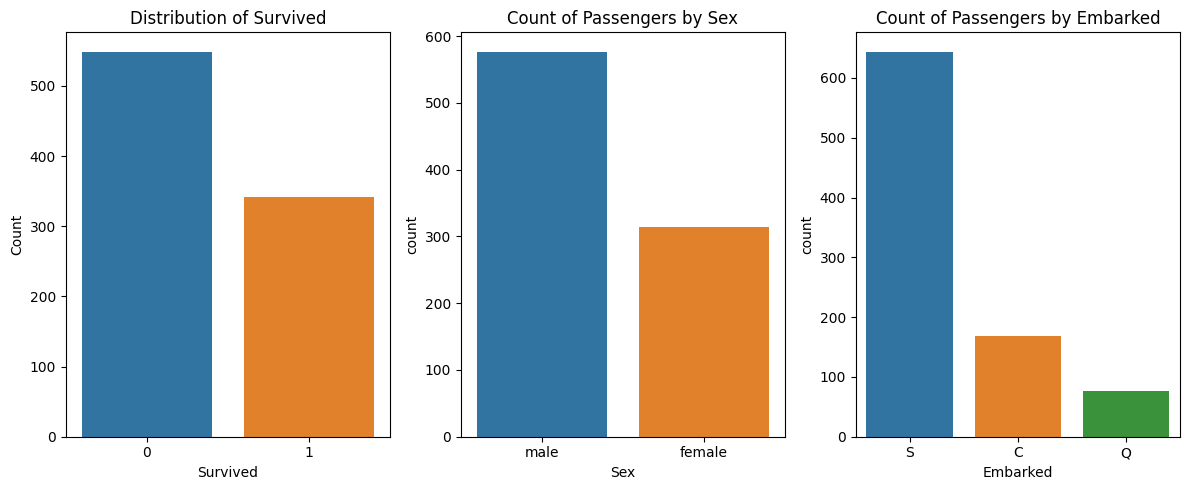

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Distribution of Survived Column
sns.countplot(x='Survived', data=train_df, ax=axes[0])
axes[0].set_title('Distribution of Survived')
axes[0].set_xlabel('Survived')
axes[0].set_ylabel('Count')

# Count of Passengers by Sex
sns.countplot(x='Sex', data=train_df, ax=axes[1])
axes[1].set_title('Count of Passengers by Sex')

# Count of Passengers by Embarked
sns.countplot(x='Embarked', data=train_df, ax=axes[2])
axes[2].set_title('Count of Passengers by Embarked')

plt.tight_layout()
plt.show()


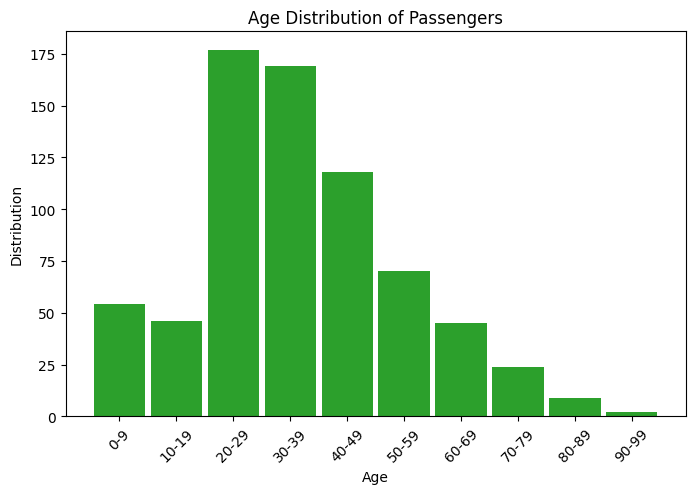

In [4]:
# Extracting age data from the dataframe
list_age = list(train_df.iloc[:,5])
bins = 10

# Setting up the figure and plotting the histogram
plt.figure('Histogram for Age', figsize=(8, 5))
plt.hist(list_age, bins, histtype='bar', rwidth=0.9)

# Adding labels and title
plt.xlabel('Age')
plt.ylabel('Distribution')
plt.title('Age Distribution of Passengers')

# Customizing x-axis ticks for better readability
bin_center = 0.5 * (plt.hist(list_age, bins, rwidth=0.9)[1][1:] + plt.hist(list_age, bins, rwidth=0.9)[1][:-1])
plt.xticks(bin_center, ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99'], rotation=45)

# Displaying the histogram
plt.show()

***Lets explore Survival counts by Sex, Class, and Age***

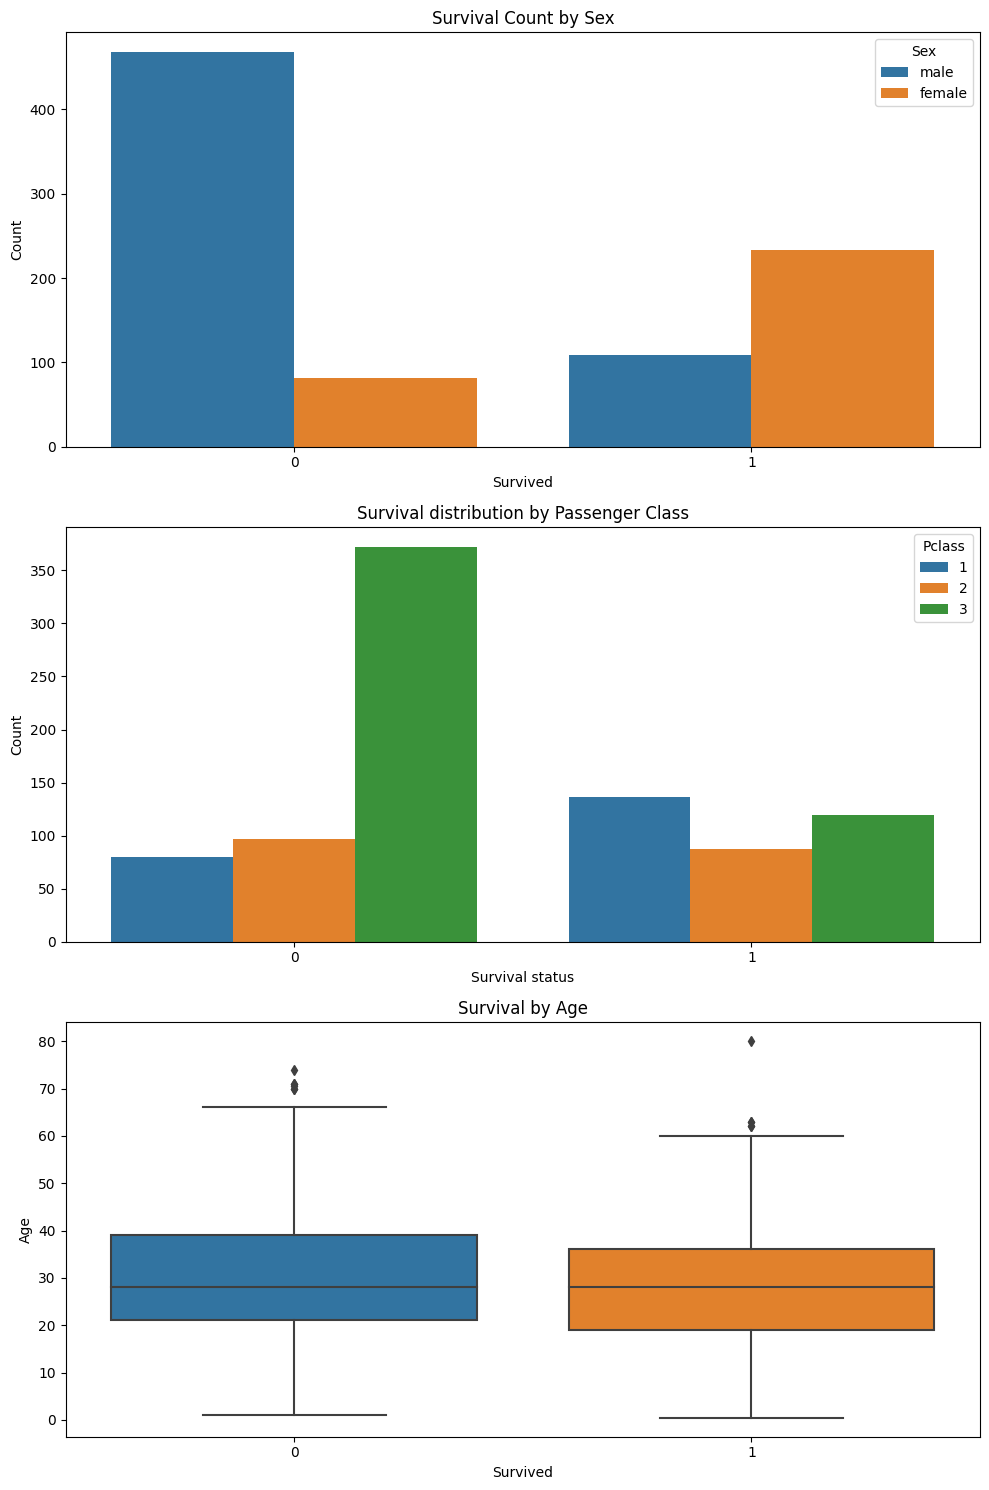

In [5]:
# Creating subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Survival Count by Sex
sns.countplot(ax=axes[0], x='Survived', hue='Sex', data=train_df)
axes[0].set_title('Survival Count by Sex')
axes[0].set_xlabel('Survived')
axes[0].set_ylabel('Count')

# Chart Survived by Pclass
sns.countplot(ax=axes[1], x='Survived', hue='Pclass', data=train_df)
axes[1].set_title('Survival distribution by Passenger Class')
axes[1].set_xlabel('Survival status')
axes[1].set_ylabel('Count')

# Survival by Age
sns.boxplot(ax=axes[2], x='Survived', y='Age', data=train_df)
axes[2].set_title('Survival by Age')
axes[2].set_xlabel('Survived')
axes[2].set_ylabel('Age')

plt.tight_layout()
plt.show()

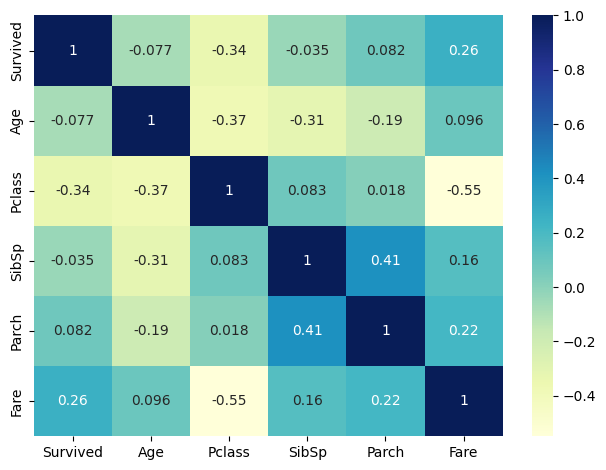

In [6]:
# Correlation Heatmap
plt.figure("Correlation Heatmap")
sns.heatmap(train_df[['Survived','Age','Pclass','SibSp','Parch','Fare']].corr(), annot=True, cmap='YlGnBu')
plt.tight_layout()
plt.show()

# Feature Engineering and Modeling

In [7]:
# Create new Family column
train_df['Family'] = train_df['SibSp'] + train_df['Parch']
test_df['Family'] = test_df['SibSp'] + test_df['Parch']

# Copy for submission
passenger_ids = test_df['PassengerId'].copy()

# Drop original 'SibSp' and 'Parch' columns
train_df = train_df.drop(['SibSp', 'Parch','PassengerId'], axis=1)
test_df = test_df.drop(['SibSp', 'Parch', 'PassengerId'], axis=1)

In [8]:
# Define features and target
features = ['Pclass', 'Sex', 'Family', 'Embarked', 'Age']
target = 'Survived'

# Extract features and target from train_df
X_train = train_df[features]
Y_train = train_df[target]

# Preprocessing steps for numerical and categorical features
numerical_features = ['Age', 'Family']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ])

# Define the model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV model to the training data
grid_search.fit(X_train, Y_train)

# Evaluate the performance
mean_cv_score = grid_search.best_score_

# Print the best hyperparameters and the mean cross-validation score
print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-Validation Mean Score:", mean_cv_score)


Best Hyperparameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Cross-Validation Mean Score: 0.8226727763480008


In [9]:
# Predict on test set
X_test = test_df[features]
predictions = grid_search.predict(X_test)

In [10]:
# Create a submission file
pred = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': predictions})

pred.to_csv('submission.csv', index=False)
pred.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
